# EIGEN ANALYSIS

### Import & Load
***

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import sys

root = os.environ['HOME']+"/private/pca-yield-curve-analytics/"
sys.path.append(root)

from src.utils import calc_rmse, std_scale_pandas, adf_test, rainbow

In [2]:
plt.rcParams.update({'font.size': 8})

In [3]:
df_train = pd.read_csv("../assets/train.csv", index_col="DATE", parse_dates=["DATE"])
df_test  = pd.read_csv("../assets/test.csv", index_col="DATE", parse_dates=["DATE"])

pca = joblib.load("../assets/pca.joblib")
pca.__dict__.keys()

dict_keys(['maturities', 'components', 'k', 'cov', 'eig_values', 'eig_vectors', 'eig_vectors_inverse', 'eig_scores', 'backtrans_rates', 'backtrans_rates_oos'])

In [4]:
eig_vectors   = pca.eig_vectors.iloc[:, :pca.k]
eig_values    = pca.eig_values
eig_scores    = pca.eig_scores.iloc[:, :pca.k]
pca_rates     = pca.backtrans_rates
pca_rates_oos = pca.backtrans_rates_oos
components    = pca.components[:pca.k]

### Eigen Vectors & Values
***

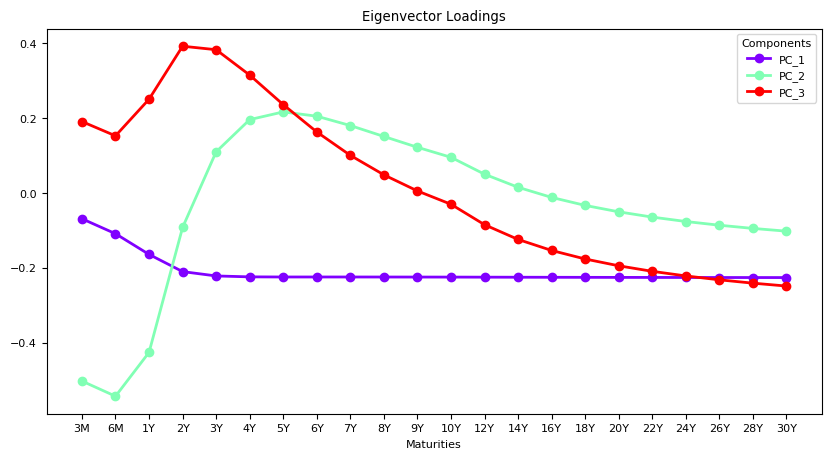

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(np.linspace(0,1,3)).values()

for (name, val), c in zip(eig_vectors.items(), color):
    ax.plot(val, c=c, label=name, linewidth=2, marker="o")

ax.set_title ("Eigenvector Loadings")
ax.set_xlabel ("Maturities")
ax.legend(title="Components")

plt.show()

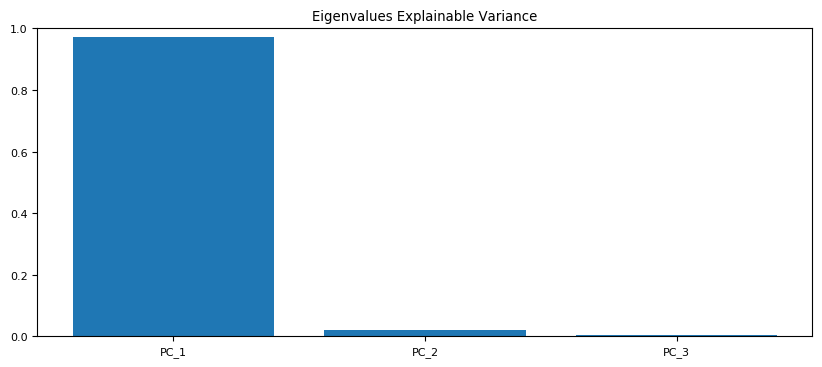

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

ax.bar(
    eig_values.index[:pca.k], 
    eig_values["relative"][:pca.k]
)

ax.set_ylim(0,1)
ax.set_title ("Eigenvalues Explainable Variance")
plt.show()

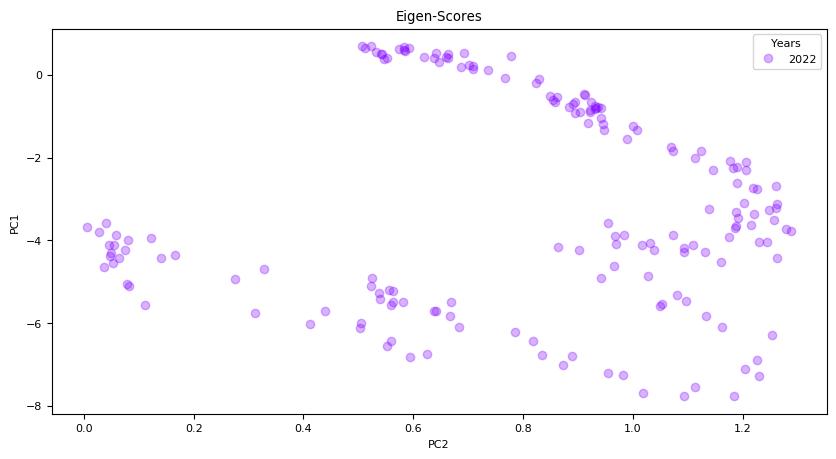

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

color = rainbow(set(eig_scores.index.year))
eig_scores_by_year = eig_scores.groupby(eig_scores.index.year)

for year, data in eig_scores_by_year:
    ax.plot(
        data["PC_2"].values, 
        data["PC_1"].values, 
        c=color[year], 
        marker="o", 
        linestyle="", 
        alpha=0.3, 
        label=year
    )

ax.set_title("Eigen-Scores")
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
plt.legend(title="Years")
plt.show()

### Yield Curve Factors
***

In [8]:
eig_scores_scaled = std_scale_pandas(eig_scores)

# Classical yield curve factors
level = std_scale_pandas(df_train["10Y"])*-1
slope = std_scale_pandas(df_train["10Y"] - df_train["6M"])
curve = std_scale_pandas(df_train["6M"] + df_train["10Y"] - 2*df_train["5Y"])

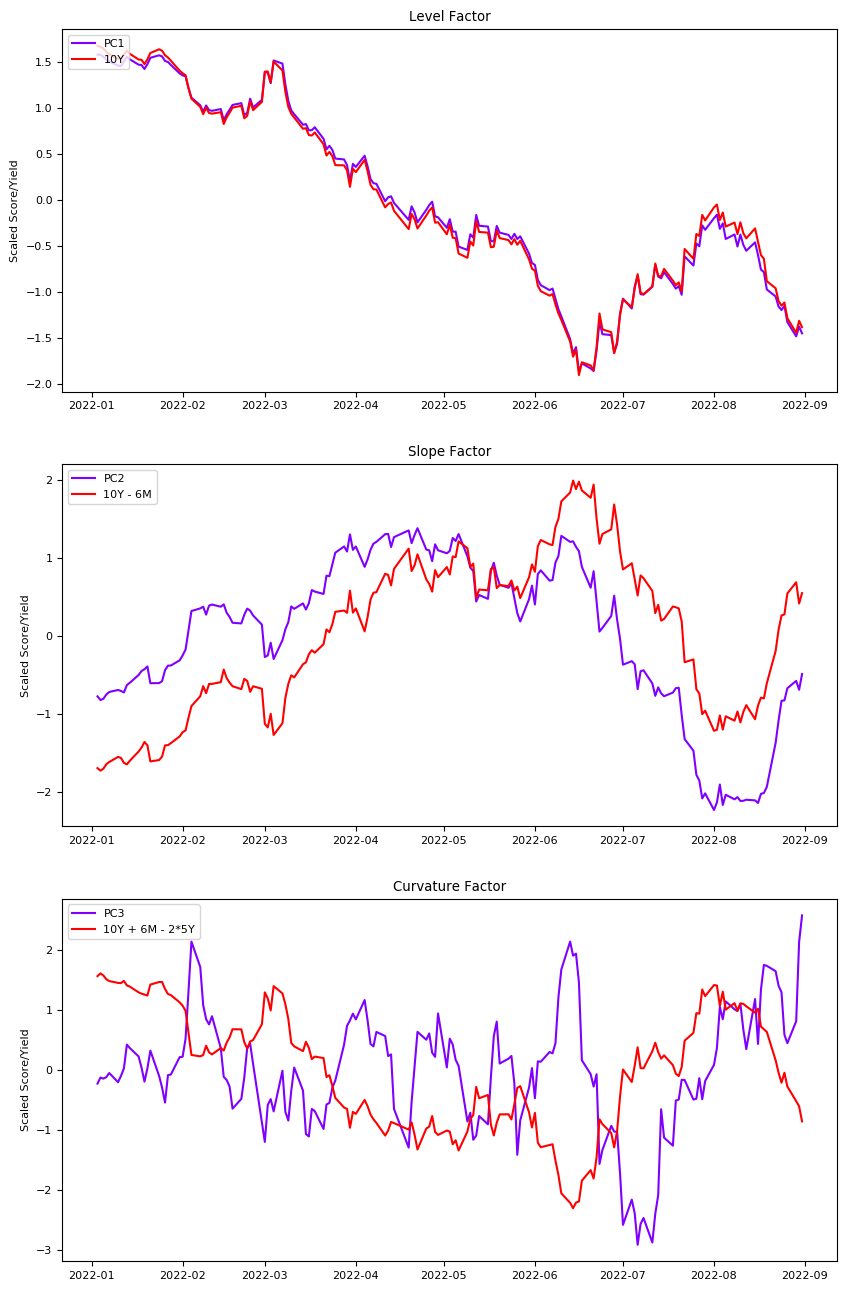

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,16))
colors = rainbow(["pca","actual"])

ax[0].plot(eig_scores_scaled["PC_1"], label="PC1", c=colors["pca"])
ax[1].plot(eig_scores_scaled["PC_2"], label="PC2", c=colors["pca"])
ax[2].plot(eig_scores_scaled["PC_3"], label="PC3", c=colors["pca"])

ax[0].plot(level, label="10Y", c=colors["actual"])
ax[1].plot(slope, label="10Y - 6M", c=colors["actual"])
ax[2].plot(curve, label="10Y + 6M - 2*5Y", c=colors["actual"])

ax[0].set_title ("Level Factor")
ax[1].set_title ("Slope Factor")
ax[2].set_title ("Curvature Factor")

for i in range (3):
    ax[i].set_ylabel ("Scaled Score/Yield")
    ax[i].legend(loc = "upper left")

plt.show()

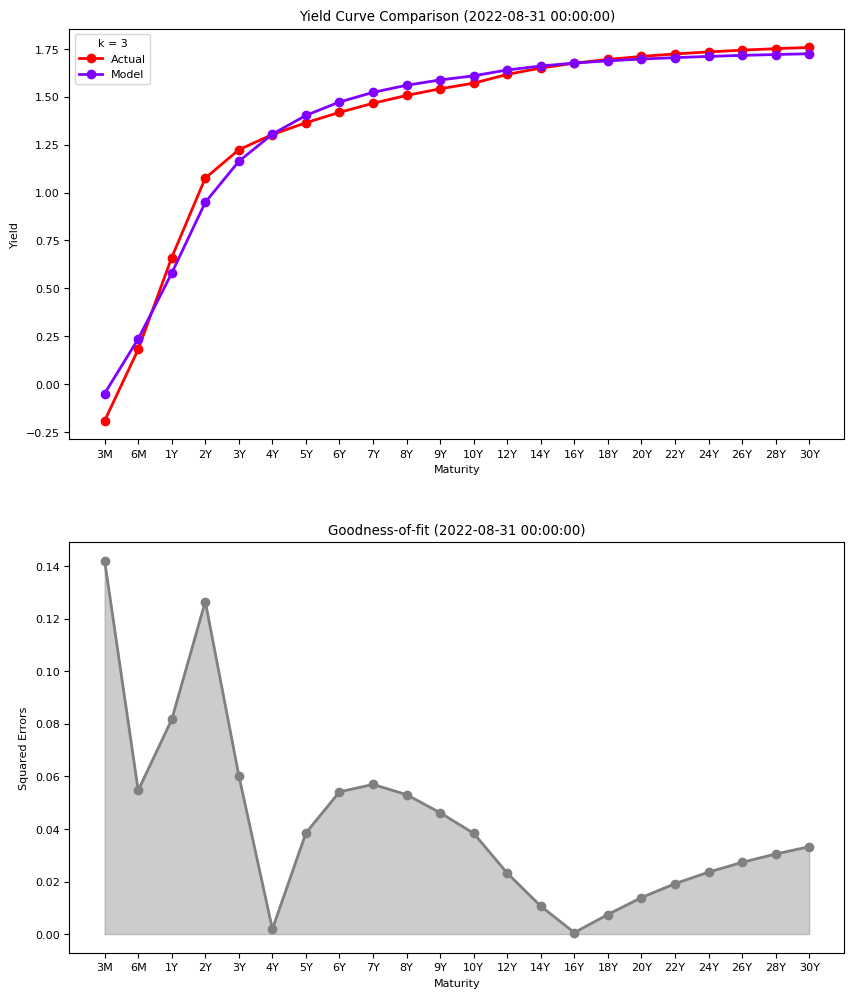

In [10]:
x = pca_rates.iloc[-1,:]
y = df_train.iloc[-1,:]
rse = np.sqrt((x-y)**2)

fig, ax = plt.subplots(nrows=2, figsize = (10,12))

ax[0].plot(y, label="Actual", c=colors["actual"], linewidth=2, marker="o")
ax[0].plot(x, label="Model",  c=colors["pca"], linewidth=2, marker="o")

ax[1].plot(rse, c="grey", linewidth=2, marker="o")
ax[1].fill_between(x.index, rse, color="grey", alpha=0.4)

ax[0].set_xlabel("Maturity")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield Curve Comparison ({df_train.index[-1]})")

ax[1].set_xlabel("Maturity")
ax[1].set_ylabel("Squared Errors")
ax[1].set_title(f"Goodness-of-fit ({df_train.index[-1]})")

ax[0].legend(title = "k = "+str(pca.k))
plt.subplots_adjust(hspace=0.25)
plt.show()

In [11]:
rmse_train = calc_rmse(df_train, pca_rates)
rmse_test = calc_rmse(df_test, pca_rates_oos)

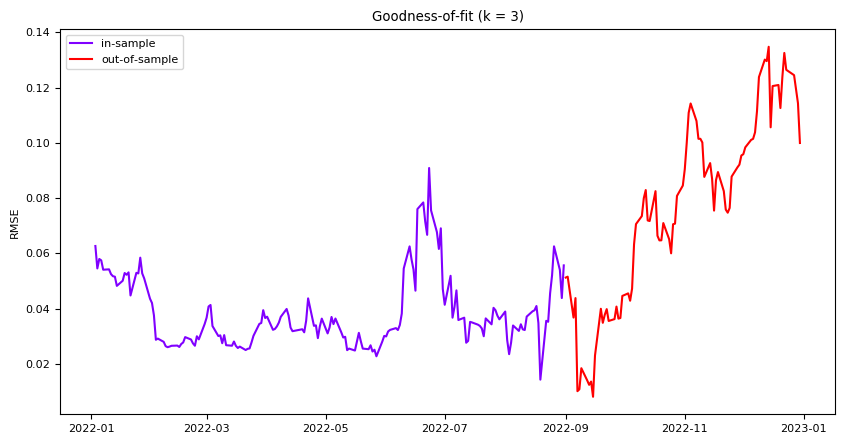

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
color = rainbow(["in-sample","out-of-sample"])

ax.plot(rmse_train, c=color["in-sample"], label="in-sample")
ax.plot(rmse_test, c=color["out-of-sample"], label="out-of-sample")

ax.set_title ("Goodness-of-fit (k = "+ str(pca.k) + ")")
ax.set_ylabel ("RMSE")
ax.legend()

plt.show()

### Stationarity Analysis
***

The Augmented Dickey-Fuller (ADF) test can be applied, to statistically testify stationarity. Basically ADF runs a regression to forecast the first differences (Y) from on the original time series (X). The resulting t-statistic gives the ADF-statistic.
- <u>Stationary:</u> When t-stat is significant. A stationary time series would be mean-reverting immediately, enabling the original time to predict the next change.
- <u>Non-Stationary:</u> When t-stat is not significant. 

In [13]:
for i in eig_vectors.columns:
    print(i, adf_test(df=eig_scores, col=i, alpha=0.05))

PC_1 {'adf_stat': -0.9141, 'p_val': 0.7833, 'threshold': -2.8787, 'stationary': 'no'}
PC_2 {'adf_stat': -1.1496, 'p_val': 0.6949, 'threshold': -2.8787, 'stationary': 'no'}
PC_3 {'adf_stat': -2.8803, 'p_val': 0.0477, 'threshold': -2.8788, 'stationary': 'yes'}


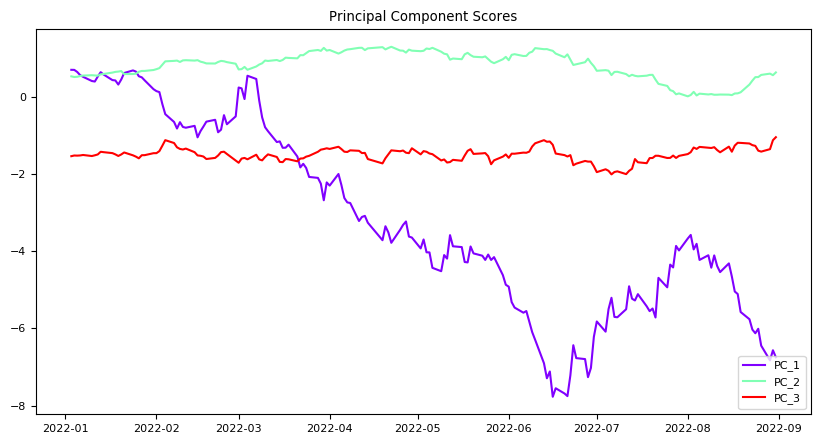

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
colors = rainbow(eig_scores.columns)

for i in components:
    plt.plot(eig_scores[i], c = colors[i], label = i)

ax.set_title ("Principal Component Scores")
ax.legend(loc = "lower right")
plt.show()

In [15]:
lag = 10

/home/bernhard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


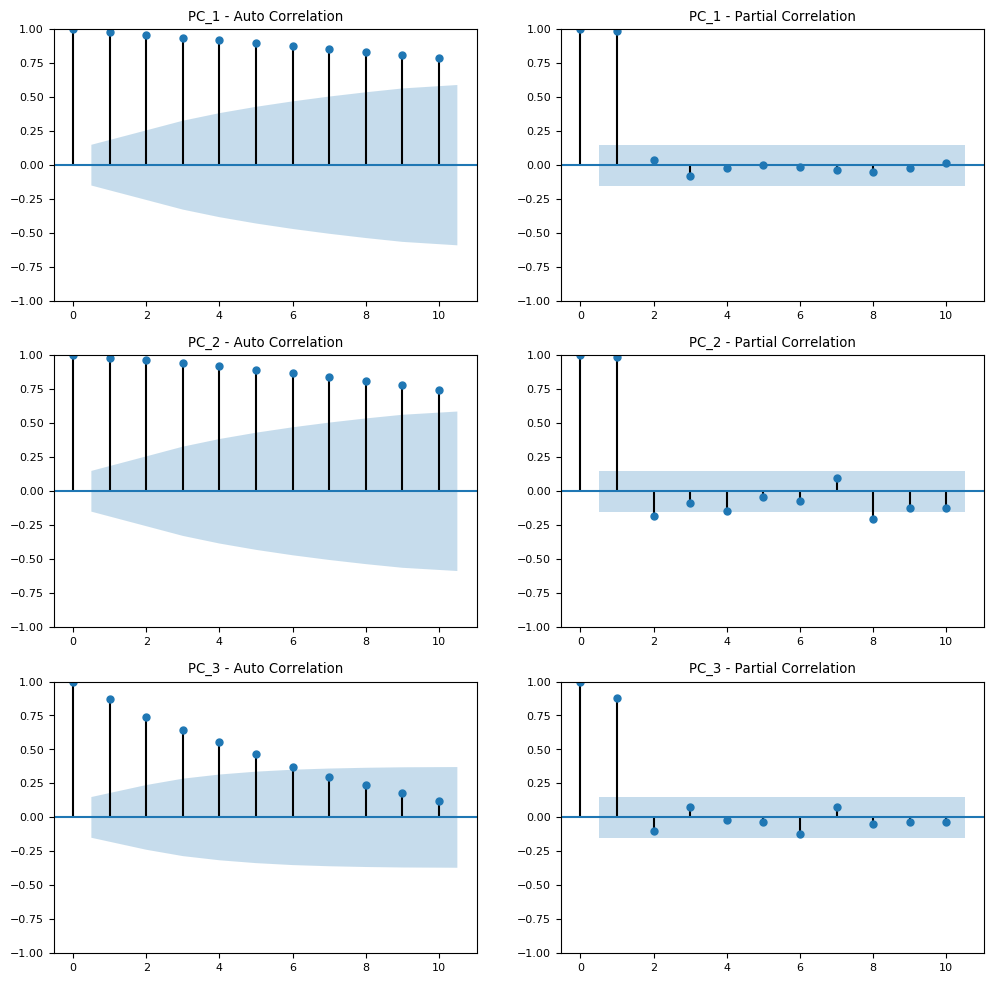

In [16]:
fig, ax = plt.subplots(nrows=pca.k, ncols=2, figsize=(12, 4*pca.k))

for i,j in enumerate (components):
    plot_acf (eig_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(eig_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

In [17]:
periods = 1

eig_scores_diff = eig_scores.diff(periods).iloc[periods:].add_suffix("_diff")
eig_scores_diff.head()

,PC_1_diff,PC_2_diff,PC_3_diff
DATE,,,
2022-01-04,-0.001166,-0.016916,0.017584
2022-01-05,-0.053593,0.005549,-0.003053
2022-01-06,-0.082319,0.019536,0.004297
2022-01-07,-0.043668,0.011657,0.012111
2022-01-10,-0.109081,0.009128,-0.027010


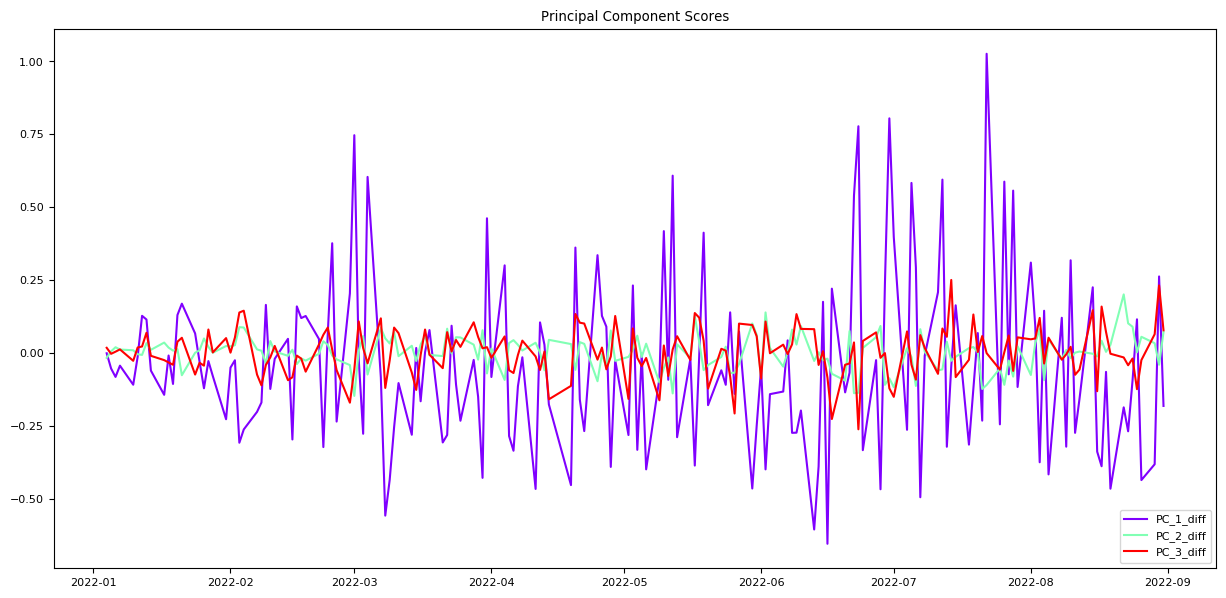

In [18]:
fig, ax = plt.subplots(figsize=(15,7))

colors = rainbow(eig_scores_diff.columns)

for i in eig_scores_diff.columns:
    plt.plot(eig_scores_diff[i], c=colors[i], label=i)

ax.set_title ("Principal Component Scores")
ax.legend(loc = "lower right")
plt.show()

In [19]:
for i in eig_scores_diff.columns:
    print (i, adf_test(df=eig_scores_diff, col=i, alpha=0.05))

PC_1_diff {'adf_stat': -13.9584, 'p_val': 0.0, 'threshold': -2.8788, 'stationary': 'yes'}
PC_2_diff {'adf_stat': -11.6631, 'p_val': 0.0, 'threshold': -2.8788, 'stationary': 'yes'}
PC_3_diff {'adf_stat': -12.1377, 'p_val': 0.0, 'threshold': -2.8788, 'stationary': 'yes'}


/home/bernhard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


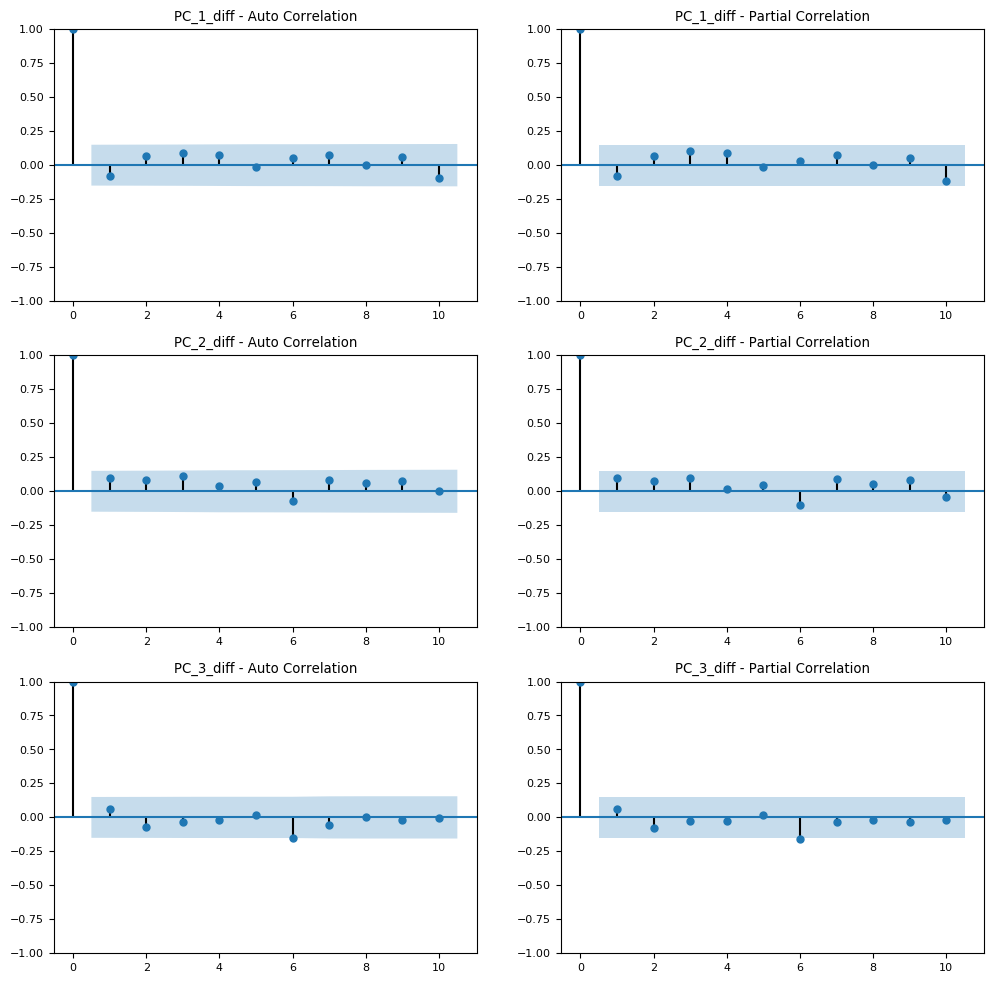

In [20]:
fig, ax = plt.subplots(nrows=pca.k, ncols=2, figsize=(12, 4*pca.k))

for i,j in enumerate (eig_scores_diff.columns):
    plot_acf (eig_scores_diff[j], lags=lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(eig_scores_diff[j], lags=lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()